# Q1 : Q-Learning
###  part1 : Implement a GridWorld class with:

*   A grid of size 4x4.

*   reset() method to return the initial state (0, 0).

*   step(action) method to take an action (0: up, 1: right, 2: down, 3: left) and return (next_state, reward, done).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Part 1: Environment Setup
class GridWorld:
    """
    Implements the 4x4 GridWorld Environment.
    """
    def __init__(self, size=4):
        self.size = size
        self.goal_state = (size - 1, size - 1)
        # Actions: 0: up, 1: right, 2: down, 3: left
        self.actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

    def reset(self):
        """Resets the agent to the starting position."""
        return (0, 0)

    def step(self, state, action):
        """
        Takes an action and returns the next state, reward, and done flag.
        """
        if state == self.goal_state:
            return state, 0, True # Should not happen if done is handled correctly

        row, col = state
        d_row, d_col = self.actions[action]

        next_row, next_col = row + d_row, col + d_col

        # Check for boundary conditions
        if not (0 <= next_row < self.size and 0 <= next_col < self.size):
            next_row, next_col = row, col # Stay in place

        next_state = (next_row, next_col)

        # Determine reward and done
        if next_state == self.goal_state:
            reward = 10
            done = True
        else:
            reward = -1
            done = False

        return next_state, reward, done



### Part 2: Q-Learning Implementation
Implement the Q-learning algorithm


In [ ]:
def state_to_index(state, size):
    """Converts a (row, col) state tuple to a single integer index."""
    return state[0] * size + state[1]

def train_q_learning(config):
    """
    Main Q-Learning training loop.

    Args:
        config (dict): A dictionary containing hyperparameters.

    Returns:
        tuple: (trained Q-table, list of rewards per episode, list of steps per episode)
    """
    # Hyperparameters
    alpha = config['alpha']
    gamma = config['gamma']
    initial_epsilon = config['initial_epsilon']
    final_epsilon = config['final_epsilon']
    is_constant_epsilon = config.get('constant_epsilon', False)

    num_episodes = 1000
    max_steps_per_episode = 50
    grid_size = 4
    num_actions = 4

    env = GridWorld(size=grid_size)
    q_table = np.zeros((grid_size * grid_size, num_actions))

    rewards_per_episode = []
    steps_per_episode = []

    epsilon = initial_epsilon

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done and steps < max_steps_per_episode:
            state_idx = state_to_index(state, grid_size)

            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.randint(0, num_actions - 1) # Explore
            else:
                action = np.argmax(q_table[state_idx, :]) # Exploit

            next_state, reward, done = env.step(state, action)
            next_state_idx = state_to_index(next_state, grid_size)
            total_reward += reward

            # Q-table update
            old_value = q_table[state_idx, action]
            next_max = np.max(q_table[next_state_idx, :])

            new_value = old_value + alpha * (reward + gamma * next_max - old_value)
            q_table[state_idx, action] = new_value

            state = next_state
            steps += 1

            if done:
                # If goal is reached, we don't count the final step
                steps_per_episode.append(steps)

        # Epsilon decay
        if not is_constant_epsilon:
            epsilon = max(final_epsilon, initial_epsilon - (initial_epsilon - final_epsilon) * (episode / num_episodes))

        rewards_per_episode.append(total_reward)
        if not done:
            steps_per_episode.append(max_steps_per_episode)

    return q_table, rewards_per_episode, steps_per_episode



### Part 3: Policy Visualization


In [ ]:
### Part 3: Policy Visualization

#This function takes the trained Q-table and prints the optimal policy derived from it
def print_policy(q_table, size=4):
    """
    Prints the learned policy as a grid of arrows.
    """
    # ↑ for action 0, → for action 1, ↓ for action 2, ← for action 3
    arrows = ['↑', '→', '↓', '←']
    policy_grid = [['' for _ in range(size)] for _ in range(size)]

    for r in range(size):
        for c in range(size):
            if (r, c) == (size - 1, size - 1):
                policy_grid[r][c] = 'G'
                continue

            state_idx = state_to_index((r, c), size)
            best_action = np.argmax(q_table[state_idx, :])
            policy_grid[r][c] = arrows[best_action]

    print("\nLearned Policy:")
    for row in policy_grid:
        print(' '.join(row))

### Part 4: Experimentation


--- Running A1. Baseline (α=0.1, γ=0.9, ε→0.1) ---

Learned Policy:
→ → → ↓
→ → → ↓
→ → → ↓
→ → → G
----------------------------------------------
--- Running A2. High Alpha (α=0.5) ---

Learned Policy:
→ → → ↓
→ → → ↓
→ → → ↓
→ → → G
----------------------------------
--- Running A3. High Gamma (γ=0.99) ---

Learned Policy:
→ ↓ ↓ ↓
→ → → ↓
→ → → ↓
→ → → G
-----------------------------------
--- Running A4. Less Initial Exploration (ε 0.5→0.1) ---

Learned Policy:
→ → ↓ ↓
→ → ↓ ↓
→ → → ↓
→ → → G
----------------------------------------------------
--- Running A5. More Final Exploitation (ε→0.01) ---

Learned Policy:
→ ↓ ↓ ↓
→ ↓ ↓ ↓
→ → → ↓
→ → → G
------------------------------------------------
--- Running B1. The Impatient Agent (Low γ=0.2) ---

Learned Policy:
↓ ↓ ↓ ↓
→ ↓ ↓ ↓
→ ↓ ↓ ↓
→ → → G
-----------------------------------------------
--- Running B2. The Greedy Agent (Low ε 0.1→0) ---

Learned Policy:
→ ↓ ↓ ↓
→ → ↓ ↓
→ → → ↓
→ → → G
----------------------------------------------

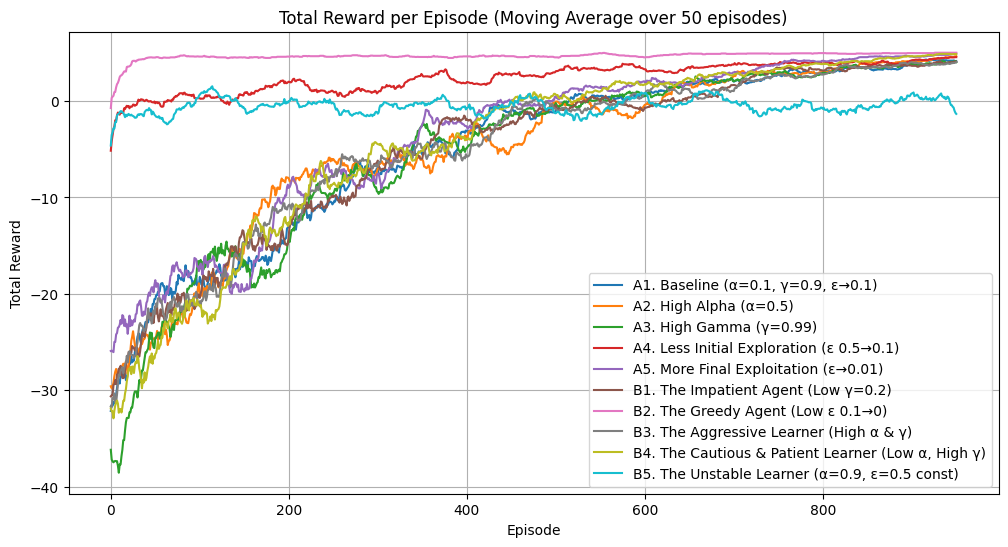

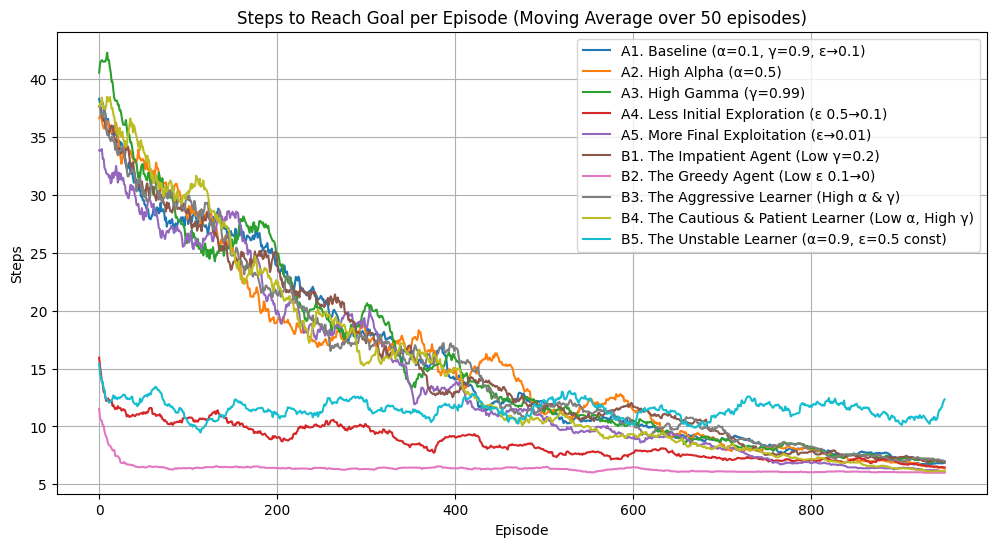

In [ ]:
def moving_average(data, window_size=50):
    """Computes the moving average of a list of numbers."""
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

if __name__ == '__main__':
    #  systematic experiment configurations
    configs = {
        # ===================================================================
        # Group A: Baseline and Single Parameter Variations
        # ===================================================================
        "A1. Baseline (α=0.1, γ=0.9, ε→0.1)": {
            'alpha': 0.1, 'gamma': 0.9, 'initial_epsilon': 1.0, 'final_epsilon': 0.1
        },
        "A2. High Alpha (α=0.5)": {
            'alpha': 0.5, 'gamma': 0.9, 'initial_epsilon': 1.0, 'final_epsilon': 0.1
        },
        "A3. High Gamma (γ=0.99)": {
            'alpha': 0.1, 'gamma': 0.99, 'initial_epsilon': 1.0, 'final_epsilon': 0.1
        },
        "A4. Less Initial Exploration (ε 0.5→0.1)": {
            'alpha': 0.1, 'gamma': 0.9, 'initial_epsilon': 0.5, 'final_epsilon': 0.1
        },
        "A5. More Final Exploitation (ε→0.01)": {
            'alpha': 0.1, 'gamma': 0.9, 'initial_epsilon': 1.0, 'final_epsilon': 0.01
        },

        # ===================================================================
        # Group B: Extreme and Interactive Effects
        # ===================================================================
        "B1. The Impatient Agent (Low γ=0.2)": {
            'alpha': 0.1, 'gamma': 0.2, 'initial_epsilon': 1.0, 'final_epsilon': 0.1
        },
        "B2. The Greedy Agent (Low ε 0.1→0)": {
            'alpha': 0.1, 'gamma': 0.9, 'initial_epsilon': 0.1, 'final_epsilon': 0.0
        },
        "B3. The Aggressive Learner (High α & γ)": {
            'alpha': 0.7, 'gamma': 0.99, 'initial_epsilon': 1.0, 'final_epsilon': 0.1
        },
        "B4. The Cautious & Patient Learner (Low α, High γ)": {
            'alpha': 0.05, 'gamma': 0.99, 'initial_epsilon': 1.0, 'final_epsilon': 0.01
        },
        "B5. The Unstable Learner (α=0.9, ε=0.5 const)": {
            'alpha': 0.9, 'gamma': 0.9, 'initial_epsilon': 0.5, 'final_epsilon': 0.5, 'constant_epsilon': True
        }
    }
    results = {}

    for name, config in configs.items():
        print(f"--- Running {name} ---")
        q_table, rewards, steps = train_q_learning(config)
        results[name] = {'rewards': rewards, 'steps': steps}
        print_policy(q_table)
        print("-" * (len(name) + 12))

    # Plotting the results
    window = 50 # For moving average

    # Plot 1: Total Reward per Episode
    plt.figure(figsize=(12, 6))
    for name, data in results.items():
        plt.plot(moving_average(data['rewards'], window), label=name)
    plt.title(f'Total Reward per Episode (Moving Average over {window} episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Steps to Reach Goal per Episode
    plt.figure(figsize=(12, 6))
    for name, data in results.items():
        plt.plot(moving_average(data['steps'], window), label=name)
    plt.title(f'Steps to Reach Goal per Episode (Moving Average over {window} episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.legend()
    plt.grid(True)
    plt.show()

# Using Pytorch  DQN Model

Episode 50/1000, Total Reward: 5
Episode 100/1000, Total Reward: 5
Episode 150/1000, Total Reward: -4
Episode 200/1000, Total Reward: 3
Episode 250/1000, Total Reward: 3
Episode 300/1000, Total Reward: 3
Episode 350/1000, Total Reward: 5
Episode 400/1000, Total Reward: 5
Episode 450/1000, Total Reward: 3
Episode 500/1000, Total Reward: 5
Episode 550/1000, Total Reward: 5
Episode 600/1000, Total Reward: 5
Episode 650/1000, Total Reward: 5
Episode 700/1000, Total Reward: 5
Episode 750/1000, Total Reward: 5
Episode 800/1000, Total Reward: 5
Episode 850/1000, Total Reward: 5
Episode 900/1000, Total Reward: 5
Episode 950/1000, Total Reward: 5
Episode 1000/1000, Total Reward: 5
Training complete.


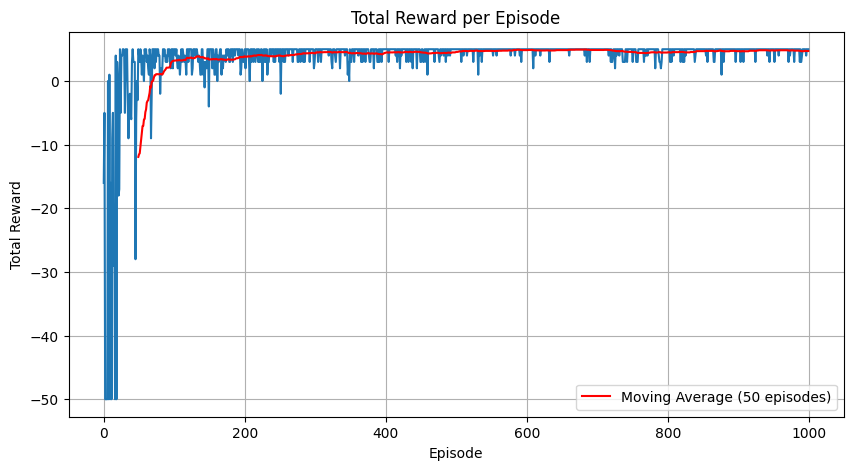


Learned Policy from DQN:
↓ ↓ → ↓
↓ ↓ ↓ ↓
↓ ↓ → ↓
→ → → G


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import namedtuple, deque
from itertools import count

# --- Environment (Same as before) ---
class GridWorld:
    def __init__(self, size=4):
        self.size = size
        self.goal_state = (size - 1, size - 1)
        self.actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

    def reset(self):
        return (0, 0)

    def step(self, state, action):
        if state == self.goal_state:
            return state, 0, True
        row, col = state
        d_row, d_col = self.actions[action]
        next_row, next_col = row + d_row, col + d_col
        if not (0 <= next_row < self.size and 0 <= next_col < self.size):
            next_row, next_col = row, col
        next_state = (next_row, next_col)
        reward = 10 if next_state == self.goal_state else -1
        done = next_state == self.goal_state
        return next_state, reward, done

# --- Replay Memory ---
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer:
    """A finite-sized buffer to store experience tuples."""
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# --- DQN Model ---
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # Input is a flattened 4x4 grid (16), output is 4 (for 4 actions)
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# --- Helper function to convert state to tensor ---
def state_to_tensor(state, size=4, device='cpu'):
    """Converts (row, col) state to a flattened 1D tensor."""
    grid = np.zeros(size * size, dtype=np.float32)
    index = state[0] * size + state[1]
    grid[index] = 1.0
    return torch.from_numpy(grid).to(device)

# --- Training Setup ---
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005 # Soft update parameter for target network
LR = 1e-4 # Learning Rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = GridWorld()

n_actions = 4
n_observations = env.size * env.size

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # Initialize target_net with policy_net's weights

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayBuffer(10000)

steps_done = 0

def select_action(state_tensor):
    """Selects an action using epsilon-greedy policy."""
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(0) will return the largest column value.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state_tensor).max(0)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_model():
    """Performs one step of the optimization."""
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Create batches of states, actions, rewards etc.
    state_batch = torch.stack(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)

    # Compute non-final next states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None]).to(device)

    # 1. Get current Q-values from policy_net: Q(s, a)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 2. Get target Q-values for next states from target_net: max_a' Q(s', a')
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # 3. Compute the expected Q values (the target): r + gamma * max_a' Q(s', a')
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # 4. Compute Loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 5. Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


# --- Main Training Loop ---
if __name__ == '__main__':
    num_episodes = 1000
    max_steps_per_episode = 50
    episode_rewards = []

    for i_episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for t in range(max_steps_per_episode):
            state_tensor = state_to_tensor(state, env.size, device)
            action_tensor = select_action(state_tensor)
            action = action_tensor.item()

            next_state, reward, done = env.step(state, action)
            total_reward += reward
            reward_tensor = torch.tensor([reward], device=device)

            if done:
                next_state_tensor = None
            else:
                next_state_tensor = state_to_tensor(next_state, env.size, device)

            # Store the transition in memory
            memory.push(state_tensor, action_tensor, next_state_tensor, reward_tensor)

            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                break

        episode_rewards.append(total_reward)
        if (i_episode + 1) % 50 == 0:
            print(f"Episode {i_episode+1}/{num_episodes}, Total Reward: {total_reward}")

    print("Training complete.")

    # --- Plotting Results ---
    plt.figure(figsize=(10,5))
    plt.title("Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.plot(episode_rewards)
    # Plot a moving average
    moving_avg = np.convolve(episode_rewards, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(len(moving_avg)) + 49, moving_avg, color='red', label='Moving Average (50 episodes)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Policy Visualization ---
    def print_policy_from_model(model, size=4):
        arrows = ['↑', '→', '↓', '←']
        policy_grid = [['' for _ in range(size)] for _ in range(size)]

        print("\nLearned Policy from DQN:")
        for r in range(size):
            for c in range(size):
                if (r, c) == env.goal_state:
                    policy_grid[r][c] = 'G'
                    continue

                state_t = state_to_tensor((r,c), size, device)
                with torch.no_grad():
                    best_action = model(state_t).max(0)[1].item()
                policy_grid[r][c] = arrows[best_action]

        for row in policy_grid:
            print(' '.join(row))

    print_policy_from_model(policy_net, env.size)

# Using Pytorch  DQN Model But with early stopping and optimisizing the steps to goal


Episode 50: New best model found! Avg steps: 19.66
Episode 51: New best model found! Avg steps: 18.78
Episode 52: New best model found! Avg steps: 18.42
Episode 53: New best model found! Avg steps: 18.28
Episode 54: New best model found! Avg steps: 17.90
Episode 55: New best model found! Avg steps: 17.38
Episode 56: New best model found! Avg steps: 17.24
Episode 57: New best model found! Avg steps: 16.56
Episode 58: New best model found! Avg steps: 16.48
Episode 59: New best model found! Avg steps: 16.32
Episode 60: New best model found! Avg steps: 16.10
Episode 61: New best model found! Avg steps: 15.24
Episode 62: New best model found! Avg steps: 14.70
Episode 63: New best model found! Avg steps: 13.82
Episode 64: New best model found! Avg steps: 13.52
Episode 65: New best model found! Avg steps: 12.86
Episode 66: New best model found! Avg steps: 12.56
Episode 67: New best model found! Avg steps: 12.04
Episode 69: New best model found! Avg steps: 11.48
Episode 70: New best model foun

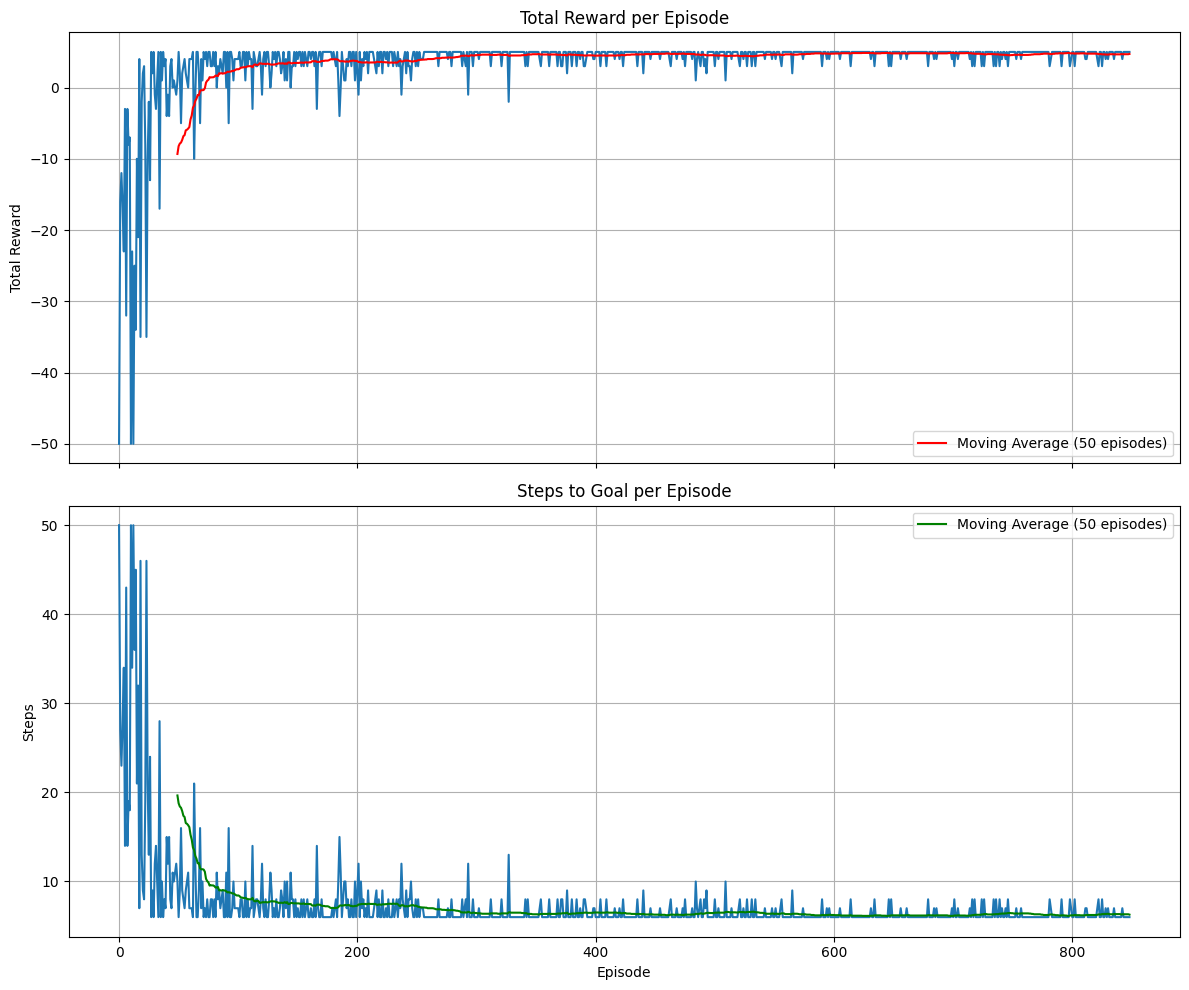


Learned Policy from Best Model:
→ → → ↓
↓ ↓ → ↓
→ ↓ ↓ ↓
→ → → G


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import namedtuple, deque
from itertools import count
import copy # Import copy for deepcopying the model state

# --- Environment, ReplayBuffer, DQN Model, and helpers (No changes here) ---
class GridWorld:
    def __init__(self, size=4):
        self.size = size
        self.goal_state = (size - 1, size - 1)
        self.actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

    def reset(self):
        return (0, 0)

    def step(self, state, action):
        if state == self.goal_state:
            return state, 0, True
        row, col = state
        d_row, d_col = self.actions[action]
        next_row, next_col = row + d_row, col + d_col
        if not (0 <= next_row < self.size and 0 <= next_col < self.size):
            next_row, next_col = row, col
        next_state = (next_row, next_col)
        reward = 10 if next_state == self.goal_state else -1
        done = next_state == self.goal_state
        return next_state, reward, done

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

def state_to_tensor(state, size=4, device='cpu'):
    grid = np.zeros(size * size, dtype=np.float32)
    index = state[0] * size + state[1]
    grid[index] = 1.0
    return torch.from_numpy(grid).to(device)

# --- Training Setup ---
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = GridWorld()

n_actions = 4
n_observations = env.size * env.size

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayBuffer(10000)

steps_done = 0

def select_action(state_tensor):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state_tensor).max(0)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    state_batch = torch.stack(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None]).to(device)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# --- Plotting and Policy Printing Functions ---
def plot_results(rewards, steps):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot rewards
    ax1.set_title("Total Reward per Episode")
    ax1.set_ylabel("Total Reward")
    ax1.plot(rewards)
    reward_moving_avg = np.convolve(rewards, np.ones(50)/50, mode='valid')
    ax1.plot(np.arange(len(reward_moving_avg)) + 49, reward_moving_avg, color='red', label='Moving Average (50 episodes)')
    ax1.legend()
    ax1.grid(True)

    # Plot steps
    ax2.set_title("Steps to Goal per Episode")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Steps")
    ax2.plot(steps)
    steps_moving_avg = np.convolve(steps, np.ones(50)/50, mode='valid')
    ax2.plot(np.arange(len(steps_moving_avg)) + 49, steps_moving_avg, color='green', label='Moving Average (50 episodes)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def print_policy_from_model(model, size=4):
    arrows = ['↑', '→', '↓', '←']
    policy_grid = [['' for _ in range(size)] for _ in range(size)]
    print("\nLearned Policy from Best Model:")
    for r in range(size):
        for c in range(size):
            if (r, c) == env.goal_state:
                policy_grid[r][c] = 'G'
                continue
            state_t = state_to_tensor((r,c), size, device)
            with torch.no_grad():
                best_action = model(state_t).max(0)[1].item()
            policy_grid[r][c] = arrows[best_action]
    for row in policy_grid:
        print(' '.join(row))

# --- Main Training Loop with Early Stopping and Model Selection ---
if __name__ == '__main__':
    num_episodes = 1000
    max_steps_per_episode = 50

    # NEW: Parameters for early stopping and model selection
    PERFORMANCE_WINDOW = 50  # Average performance over last 50 episodes
    EARLY_STOPPING_PATIENCE = 150 # Stop if no improvement for 150 episodes

    # NEW: Tracking variables
    episode_rewards = []
    episode_steps = []
    recent_steps = deque([], maxlen=PERFORMANCE_WINDOW)

    best_average_steps = float('inf')
    best_model_state_dict = None
    episodes_since_last_improvement = 0

    for i_episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for t in range(max_steps_per_episode):
            state_tensor = state_to_tensor(state, env.size, device)
            action_tensor = select_action(state_tensor)
            action = action_tensor.item()

            next_state, reward, done = env.step(state, action)
            total_reward += reward
            reward_tensor = torch.tensor([reward], device=device)

            if done:
                next_state_tensor = None
            else:
                next_state_tensor = state_to_tensor(next_state, env.size, device)

            memory.push(state_tensor, action_tensor, next_state_tensor, reward_tensor)
            state = next_state
            optimize_model()

            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                break

        # Record episode results
        episode_rewards.append(total_reward)
        episode_steps.append(t + 1)
        recent_steps.append(t + 1)

        # --- NEW: Check for improvement and early stopping ---
        if i_episode >= PERFORMANCE_WINDOW -1: # Start checking after the first window is full
            current_average_steps = np.mean(recent_steps)

            if current_average_steps < best_average_steps:
                best_average_steps = current_average_steps
                # Use deepcopy to ensure the state isn't a reference that keeps changing
                best_model_state_dict = copy.deepcopy(policy_net.state_dict())
                episodes_since_last_improvement = 0
                print(f"Episode {i_episode+1}: New best model found! Avg steps: {best_average_steps:.2f}")
            else:
                episodes_since_last_improvement += 1

            if episodes_since_last_improvement >= EARLY_STOPPING_PATIENCE:
                print(f"\nStopping early at episode {i_episode+1}. No improvement for {EARLY_STOPPING_PATIENCE} episodes.")
                break

    print("Training complete.")

    # --- NEW: Load the best performing model before visualizing ---
    if best_model_state_dict:
        print(f"\nLoading best model with average steps: {best_average_steps:.2f}")
        policy_net.load_state_dict(best_model_state_dict)
    else:
        print("\nNo best model was saved. Using the final model.")

    # Plotting and visualizing the policy of the best model
    plot_results(episode_rewards, episode_steps)
    print_policy_from_model(policy_net, env.size)